In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [18]:
### Physical Constant ###
### DO NOT EDIT ###

# Specific Ionic constants     (l/g_ion)

HNa  = -0.550
HCa  = -0.303
HMg  = -0.314
HH   = -0.774
HCl  =  0.844
HCO3 =  0.485
HHO  =  0.941


# Molecular masses     (g/mol)

MNaCl  = 58.5
MCaCO3 = 90
MMgCl2 = 95
MNa    = 23
MCa    = 40
MMg    = 24
MCl    = 35.5
MCO3   = 60 


# Kinetic constants
   
miu_P  = 1.790      # [1/h]
Ks     = 1.030      # [g/l]
Ks1    = 1.680      # [g/l]      
Kp     = 0.139      # [g/l]
Kp1    = 0.070      # [g/l]
Rsx    = 0.607
Rsp    = 0.435
YO2    = 0.970      # [mg/mg]
KO2    = 8.86       # [mg/l]
miu_O2 = 0.5        # [1/h]
A1     = 9.5e8
A2     = 2.55e33
Ea1    = 55000      # J/mol
Ea2    = 220000     # J/mol
R      = 8.31       # J/(mol.K)


# thermodynamic constants

Kla0   = 38        # [1/h]
KT     = 100*3600  # [J/hm2K]
Vm     = 50        # [l]
AT     = 1         # [m2]
ro     = 1080      # [g/l]
ccal   = 4.18      # [J/gK]         
roag   = 1000      # [g/l]
ccalag = 4.18      # [J/gK]
deltaH = 518       # [kJ/mol O2 consumat]

 
# Initial data

mNaCl  = 500        # [g]
mCaCO3 = 100        # [g]
mMgCl2 = 100        # [g]
pH     = 6
Tiag   = 15         # [癈]


# Initial Conditions

x0 = [1000, 0.90467678228155, 12.51524128083789, 29.73892382828279, 3.10695341758232, 29.57321214183856, 27.05393890970931]


In [19]:
def linearized_model(t, vars, Fi, Fe, T_in, cS_in, Fag):
    V, cX, cP, cS, cO2, T, Tag = vars
    t_index = np.mod(t, 1)
    t_index = int(t_index * T_POINT)

    # Handle callable or list inputs
    if callable(Fi):
        Fi = Fi(t)
    else:
        Fi = Fi[t_index]
    if callable(Fe):
        Fe = Fe(t)
    else:
        Fe = Fe[t_index]
    if callable(T_in):
        T_in = T_in(t)
    else:
        T_in = T_in[t_index]
    if callable(cS_in):
        cS_in = cS_in(t)
    else:
        cS_in = cS_in[t_index]
    if callable(Fag):
        Fag = Fag(t)
    else:
        Fag = Fag[t_index]

    # Define constants (replace with actual values)
    deltaH = -50000  # Reaction enthalpy (J/mol)
    K_T = 10  # Heat transfer coefficient (W/m²·K)
    A_T = 1  # Heat transfer area (m²)
    rho = 1000  # Density (kg/m³)
    c_cal = 4.18  # Specific heat capacity (kJ/kg·K)
    roag = 1.2  # Air density (kg/m³)
    ccalag = 1.005  # Specific heat of air (kJ/kg·K)
    Vm = 1  # Reactor volume (m³)
    Tiag = 25  # Air inlet temperature (°C)
    Kla0 = 0.01  # Mass transfer coefficient base value
    miu_O2 = 0.01  # Oxygen uptake rate coefficient
    R = 8.314  # Universal gas constant (J/mol·K)
    Ea1 = 50000  # Activation energy 1 (J/mol)
    A1 = 1e10  # Pre-exponential factor 1
    Ea2 = 60000  # Activation energy 2 (J/mol)
    A2 = 1e8  # Pre-exponential factor 2
    Ks = 0.5  # Half-saturation constant for substrate
    Kp = 0.1  # Product inhibition constant
    miu_P = 0.05  # Product formation rate coefficient
    Rsx = 1.2  # Substrate to biomass yield coefficient
    Rsp = 1.1  # Substrate to product yield coefficient
    KO2 = 0.01  # Half-saturation constant for oxygen
    YO2 = 0.5  # Oxygen yield coefficient

    # Steady-state values (replace with actual values)
    T_0, Tag_0, V_0, Fi_0, Fe_0, rO2_0 = 25, 25, 1, 51, 51, 0.01

    # Perturbation variables
    Delta_T = T - T_0
    Delta_Tag = Tag - Tag_0
    Delta_Fi = Fi - Fi_0
    Delta_Fe = Fe - Fe_0
    Delta_rO2 = miu_O2 * (cO2 - 0.01)  # Simplified oxygen uptake rate change

    # Linearized dT
    dT_linearized = (
        1 / (32 * V_0) * (
            V_0 * Delta_rO2 * deltaH
            - K_T * A_T * (Delta_T - Delta_Tag)
            + rho * c_cal * (T_in * Delta_Fi - T_0 * Delta_Fi - Fi_0 * Delta_T - Fe_0 * Delta_T)
        )
    )

    # Other state equations
    dV = Fi - Fe
    miu_X = A1 * np.exp(-Ea1 / (R * (T + 273))) - A2 * np.exp(-Ea2 / (R * (T + 273)))
    dcX = miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) - (Fe / V) * cX
    dcP = miu_P * cX * cS / (Ks + cS) * np.exp(-Kp * cP) - (Fe / V) * cP
    dcS = (
        -miu_X * cX * cS / (Ks + cS) * np.exp(-Kp * cP) / Rsx
        - miu_P * cX * cS / (Ks + cS) * np.exp(-Kp * cP) / Rsp
        + (Fi / V) * cS_in
        - (Fe / V) * cS
    )
    Kla = Kla0 * (1.024 ** (T - 20))
    cst = 14.16 - 0.3943 * T + 0.007714 * T**2 - 0.0000646 * T**3
    dcO2 = Kla * (cst - cO2) - Delta_rO2 - (Fe / V) * cO2
    dTag = (Fag * ccalag * roag * (Tiag - Tag) + K_T * A_T * (T - Tag)) / (Vm * roag * ccalag)

    return [dV, dcX, dcP, dcS, dcO2, dT_linearized, dTag]


In [20]:
### If you are interested, the simulation is achieved by runing the model without the time delay and mannully shift the time for the model.
### The feedback is achieved by accessing the process output on previous time (time delay enables this).

## solve one step of the model, time is an array [t_initial, t_end]
def solve_step_linearized(time, x0, Fi, Fe, T_in, cS_in, Fag, result):
    t_eval = np.linspace(time[0],time[1],T_POINT)
    ### changed to BDF method stablized the oxygen concentration
    sol = scipy.integrate.solve_ivp(linearized_model, time, x0,args=(Fi,Fe,T_in,cS_in,Fag), t_eval=t_eval, method='BDF')
    if time[0] == 0:
        result = np.concatenate((result, sol.y), axis=1)
    else:
        result = np.concatenate((result, sol.y[:,1:]), axis=1)
    return result

## Find the current output of your system time is integer and returns the process data for 1 step with number of point equal to T_POINT
def current_output(time, result):
    process_time = int(time*(T_POINT-1))
    return result[:,process_time:int((time+1)*(T_POINT-1)+1)]

## Find the setpoint of your process.
def set_point_linearized(time, x0):
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        if i == 0:
            x0=x0
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18
        result = solve_step_linearized([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    return result

In [21]:
## Function that runs the entie feedback loop. time is an array with [t_inital, t_end], x0 is the initial condition
def dynamic_model_linearized(time, x0):
    result_sp = set_point_linearized(time, x0)
    result = np.zeros([7,T_DELAY*(T_POINT-1)])
    for i in range(time[1]-T_DELAY):
        ##Cover the edge case
        if i == 0:
            x0=x0

        V, Cx, Cp, Cs, Co2, T, Tag = current_output(i,result) # find the current output of the process
        Vsp, Cxsp, Cpsp, Cssp, Co2sp, Tsp, Tagsp = current_output(i,result_sp) # Find the current setpoint of the process
        ## process input, you may need to specify as disturbance in the problem statement or you need to use controller to adjust the input
        Fi = lambda t: 51
        Fe = lambda t: 51
        T_in = lambda t: 25
        cS_in = lambda t: 60
        Fag = lambda t: 18

        ## Find your error

        ## Construct your transfer function


        t_eval = np.linspace(i,i+1,T_POINT) ## your transfer function should evaluate on the same time point as the model (this is your sampling point)
        
        ## Simulate your input to the model
       
        ## Your solve_step can take both a callable function for Fi, Fe, T_in, cS_in, Fag or an array of data at the given [i, i+1] time window.
        ## ie your simulated input to process can be directly feed into the solve_step, and you can also define disturbance as function and pass into the solve_step
        result = solve_step_linearized([i, i+1], x0, Fi, Fe, T_in, cS_in, Fag, result)
        x0 = result[:,-1]
    t = np.linspace(time[0],time[1],(time[1] - time[0])*(T_POINT-1)+1) ## entire sampling time for the process 
    return t, result, result_sp


t_final = 1000 ### final time for you model
t, result, result_sp = dynamic_model_linearized([0,t_final], x0) ### run the model

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_7018/434254984.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("Tank Temperature ($^{\circ} C$)")
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_7018/434254984.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


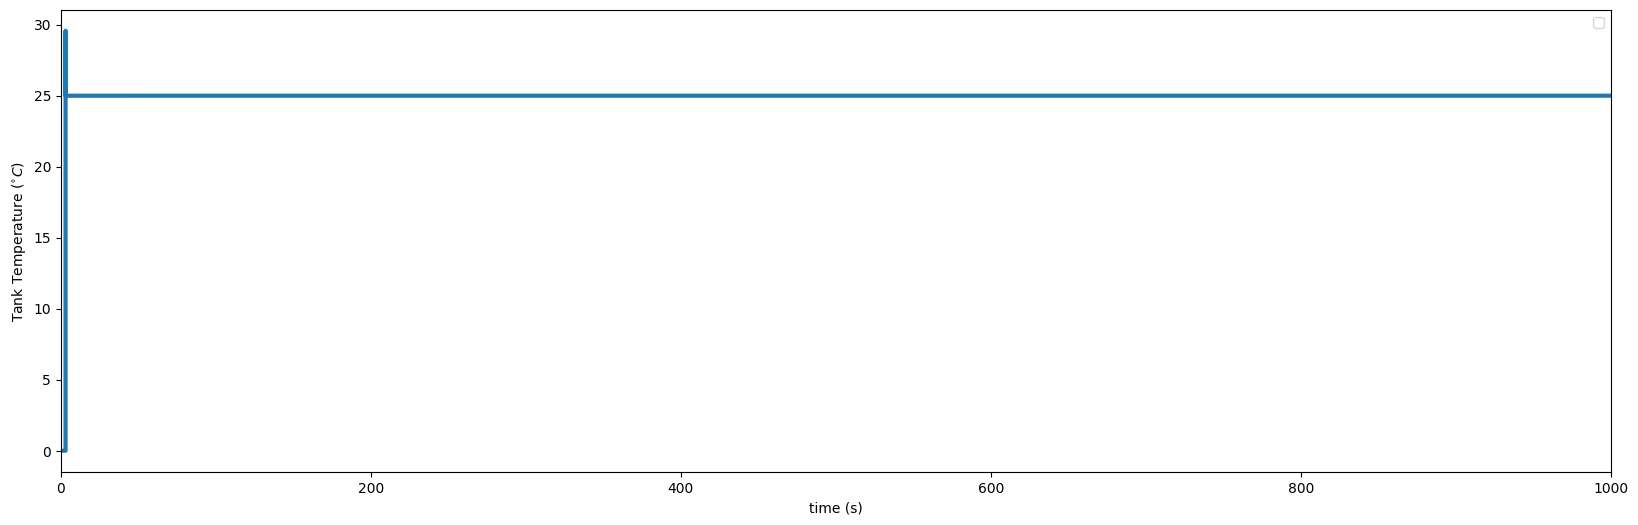

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(t,result[5],lw=3)
plt.xlim([0,t_final])
plt.xlabel("time (s)")
plt.ylabel("Tank Temperature ($^{\circ} C$)")
plt.legend()